### Initial Imports

In [16]:
#Importing Necessary Packages

import numpy as np
import pandas as pd
import sys
import gc
import pickle
import datetime
from itertools import product
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#Importing all datasets

items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')
item_categories = pd.read_csv('data/item_categories.csv')
sales_train = pd.read_csv('data/sales_train_v2.csv')
test  = pd.read_csv('data/test.csv') 

In [6]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [8]:
#Indexing ID Column

test  = test.set_index('ID')

### Data Preprocessing

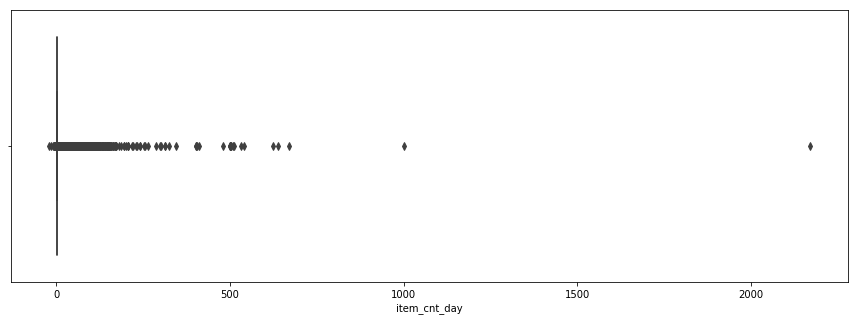

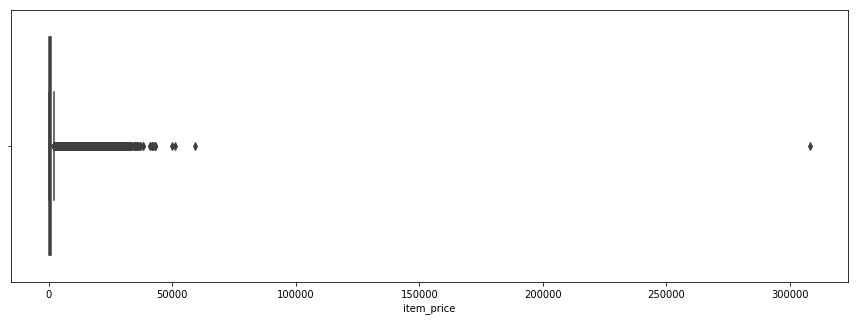

In [12]:
# Checking Outliers

plt.figure(figsize=(15,5))
sns.boxplot(x=sales_train['item_cnt_day'])

plt.figure(figsize=(15,5))
sns.boxplot(x=sales_train['item_price'])

In [13]:
# Removing Outliers

sales_train = sales_train[sales_train['item_price']<100000]
sales_train = sales_train[sales_train['item_cnt_day']<1001]

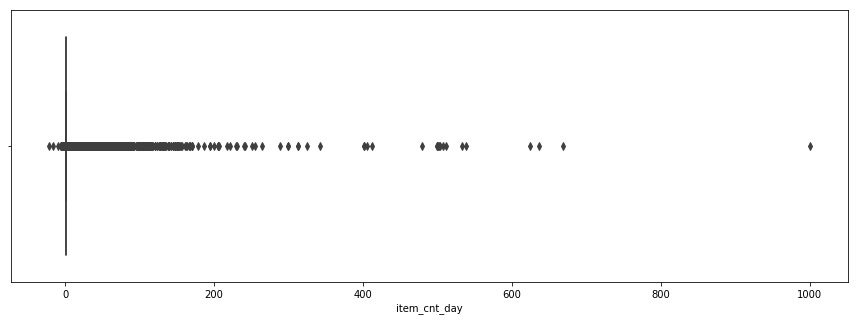

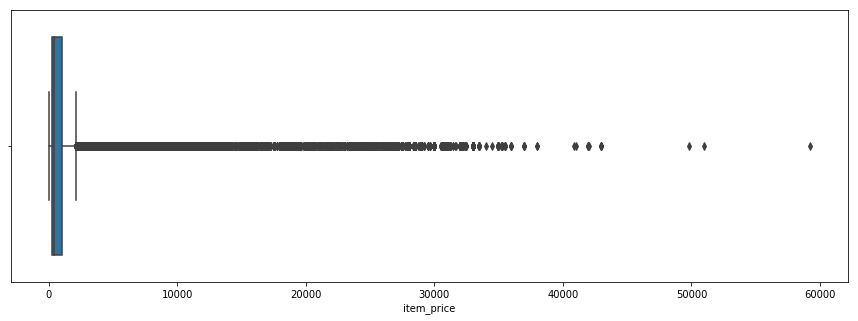

In [14]:
# Checking Outliers Again

plt.figure(figsize=(15,5))
sns.boxplot(x=sales_train['item_cnt_day'])

plt.figure(figsize=(15,5))
sns.boxplot(x=sales_train['item_price'])

In [17]:
#Formatting the date column correctly

sales_train.date=sales_train.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935847 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 156.8 MB
None


In [18]:
print(sales_train.min())
print(sales_train.max())

date              2013-01-01 00:00:00
date_block_num                      0
shop_id                             0
item_id                             0
item_price                         -1
item_cnt_day                      -22
dtype: object
date              2015-10-31 00:00:00
date_block_num                     33
shop_id                            59
item_id                         22169
item_price                      59200
item_cnt_day                     1000
dtype: object


In [19]:
sales_train[sales_train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [21]:
#Imputing the above record
median_val = sales_train[(sales_train.shop_id==32)&(sales_train.item_id==2973)&(sales_train.date_block_num==4)&(sales_train.item_price>0)].item_price.median()
sales_train.loc[sales_train.item_price<0, 'item_price'] = median_val

In [27]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [30]:
#On closely observing the above data, we can see some duplicates

In [32]:
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [44]:
sales_train['shop_id'].unique()

array([59, 25, 24, 23, 19, 22, 18, 21, 28, 27, 29, 26,  4,  6,  2,  3,  7,
       57, 58, 16, 15,  8, 11, 14, 13, 12, 53, 31, 30, 32, 35, 56, 54, 47,
       50, 42, 43, 52, 51, 41, 38, 44, 37, 46, 45,  5, 55, 17,  9, 49, 39,
       40, 48, 34, 33, 20, 36], dtype=int64)

In [51]:
#Preprocessing Secondary Supporting Tables - Shops,Item Categories & Items

In [45]:
shops.loc[shops.shop_id == 0, 'shop_id'] = 57
shops.loc[shops.shop_id == 1, 'shop_id'] = 58
shops.loc[shops.shop_id == 10, 'shop_id'] = 11

In [46]:
shops['shop_id'].unique()

array([57, 58,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 59], dtype=int64)

In [47]:
#Fixing bad shop names and extracting city name from shop name

shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city_name'] = shops['shop_name'].str.split(' ').map(lambda z: z[0])
shops.loc[shops.city_name == '!Якутск', 'city_name'] = 'Якутск'

In [48]:
shops.head()

,shop_name,shop_id,city_name
0,"!Якутск Орджоникидзе, 56 фран",57,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",58,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [49]:
#One hot encoding categorical variables
shops['city_id'] = LabelEncoder().fit_transform(shops['city_name'])
shops = shops[['shop_id','city_id']]

In [50]:
shops.head()

,shop_id,city_id
0,57,29
1,58,29
2,2,0
3,3,1
4,4,2


In [52]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [55]:
#Splitting category names and one-hot encoding categorical variables

item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type_name'] = item_categories['split'].map(lambda z: z[0].strip())
item_categories['type_id'] = LabelEncoder().fit_transform(item_categories['type_name'])
item_categories['subtype'] = item_categories['split'].map(lambda z: z[1].strip() if len(z) > 1 else z[0].strip())
item_categories['subtype_id'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_id', 'subtype_id']]

In [56]:
item_categories.head()

,item_category_id,type_id,subtype_id
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [58]:
items.drop(['item_name'], axis=1, inplace=True) #Dropping item names as it is irrelevant

In [62]:
# Merging sales train data for all combinations 

sales_train_merged = []
cols = ['date_block_num','shop_id','item_id']
date_block_num_max = sales_train['date_block_num'].max()
for i in range(date_block_num_max+1):
    sales = sales_train[sales_train.date_block_num==i]
    sales_train_merged.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique()))))
    
sales_train_merged = pd.DataFrame(np.vstack(sales_train_merged), columns=cols)
sales_train_merged.sort_values(cols,inplace=True)

In [64]:
sales_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913804 entries, 114910 to 10770465
Data columns (total 3 columns):
date_block_num    int64
shop_id           int64
item_id           int64
dtypes: int64(3)
memory usage: 333.1 MB


In [65]:
#Changing datatypes to reduce datframe size
sales_train_merged['date_block_num'] = sales_train_merged['date_block_num'].astype(np.int8)
sales_train_merged['shop_id'] = sales_train_merged['shop_id'].astype(np.int8)
sales_train_merged['item_id'] = sales_train_merged['item_id'].astype(np.int16)

In [66]:
sales_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913804 entries, 114910 to 10770465
Data columns (total 3 columns):
date_block_num    int8
shop_id           int8
item_id           int16
dtypes: int16(1), int8(2)
memory usage: 124.9 MB


In [68]:
#Creating a new column

sales_train['revenue'] = sales_train['item_price'] *  sales_train['item_cnt_day']

In [69]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,2013-01-02,0,59,22154,999.00,1.0,999.00
1,2013-01-03,0,25,2552,899.00,1.0,899.00
2,2013-01-05,0,25,2552,899.00,-1.0,-899.00
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00


In [70]:
#Grouping by month and calculating total sales per month
sales_train_agg = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
sales_train_agg.columns = ['item_cnt_month']
sales_train_agg.reset_index(inplace=True)

In [72]:
sales_train_agg.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [73]:
# Merging with sales_train_merged data
sales_train_merged = pd.merge(sales_train_merged, sales_train_agg, on=cols, how='left')

In [74]:
sales_train_merged.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,NaN
1,0,2,27,1.0
2,0,2,28,NaN
3,0,2,29,NaN
4,0,2,32,NaN


In [80]:
sales_train_merged['item_cnt_month'] = sales_train_merged['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16)

In [81]:
sales_train_merged.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [82]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [83]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [84]:
test.head()

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [86]:
#Adding test data to sales_train as 34th month

sales_train_merged = pd.concat([sales_train_merged, test], ignore_index=True, sort=False, keys=cols)
sales_train_merged.fillna(0, inplace=True) 

In [87]:
sales_train_merged.tail()

,date_block_num,shop_id,item_id,item_cnt_month
11342199,34,45,18454,0.0
11342200,34,45,16188,0.0
11342201,34,45,15757,0.0
11342202,34,45,19648,0.0
11342203,34,45,969,0.0


In [88]:
#Merging sales_train_merged with every other table
sales_train_merged = pd.merge(sales_train_merged, shops, on=['shop_id'], how='left')
sales_train_merged = pd.merge(sales_train_merged, items, on=['item_id'], how='left')
sales_train_merged = pd.merge(sales_train_merged, item_categories, on=['item_category_id'], how='left')
sales_train_merged['city_id'] = sales_train_merged['city_id'].astype(np.int8)
sales_train_merged['item_category_id'] = sales_train_merged['item_category_id'].astype(np.int8)
sales_train_merged['type_id'] = sales_train_merged['type_id'].astype(np.int8)
sales_train_merged['subtype_id'] = sales_train_merged['subtype_id'].astype(np.int8)

In [89]:
sales_train_merged.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,type_id,subtype_id
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4


In [90]:
sales_train_merged.tail()

,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,type_id,subtype_id
12074532,34,45,18454,0.0,20,55,13,2
12074533,34,45,16188,0.0,20,64,14,42
12074534,34,45,15757,0.0,20,55,13,2
12074535,34,45,19648,0.0,20,40,11,4
12074536,34,45,969,0.0,20,37,11,1


In [91]:
#Saving Milestone 1
sales_train_merged.to_pickle('sales_train_merged.pkl')